**We will highlight a detailed step by step procedure of developing a Deep Learning model which enables us to classify fashion mnist images into multiple classes

## Connecting to a GPU

First open Google Coloaboratory. On the Menu Bar, go to Runtime > Change runtime type. Select GPU and click Save.

We then check the GPU information using the `nvidia-smi` command

In [1]:
!nvidia-smi

Sat Dec  4 10:39:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mounting your Google Drive

Run the following command to mount your Google Drive into the Google Colaboratory environment. After running this code cell, a link will appear. Follow that link and grant access to Google Drive. You will get an authentication key which you need to copy and paste into an input box under this cell, and press Enter on yor keyboard.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


## Loading necessary libraries

In [50]:
# loading packages
import os
import matplotlib.pyplot as plt
import cv2
import random
import collections
from google.colab import files
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Loading the dataset

We can now extract the dataset from our Google Drive into a temporary folder called `dataset` in our Google Colaboratory runtime. Please note that this folder will be automatically removed from memory once your Google Colaboratory session ends or terminates. You will need to remount your drive and run the below code to extract the dataset again in the future.

In [23]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [24]:
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


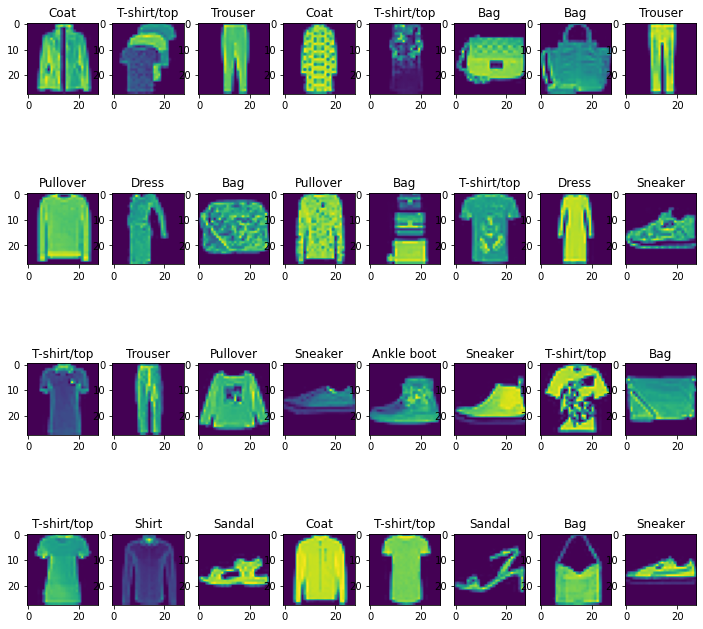

In [25]:
# Visualizing some Covid samples from the dataset
plt.figure(figsize = (12,12))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    x = random.randint(0, x_train.shape[0])
    img = x_train[x]
    label = classes[y_train[x]]
    plt.imshow(img)
    plt.title(label)

plt.show()

In [26]:
#scaling images and expanding dimm
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [27]:
classes = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

In [28]:
# checking distribution
class_count =collections.Counter(y_train)
print('train_set class count',class_count)
class_count =collections.Counter(y_test)
print('test_set class count',class_count)

train_set class count Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
test_set class count Counter({9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000})


classes are evenly distributed

## Dataset Visualization

Let us view some samples of each class within our dataset.

### Visualizing some Covid samples from the dataset

In [29]:
#after resizing
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [30]:
#coverting classes to binary coding
y_train = to_categorical(y_train,10)
y_test =to_categorical(y_test,10)

Now, we define some training hyperparameters:

*   img_width: Width of input image in pixels
*   img_height: Height of input image in pixels
*   channels: Numbers of color channels in image
*   batch_size: The number of training samples to work through before the model’s internal parameters are updated 
*   validation_steps: validation_set_size / batch_size
*   classes_num: Number of classes, 3 in our case
*   lr: Learning Rate. The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. It  controls how quickly the model is adapted to the problem
*   epochs: The number of epochs controls the number of complete passes through the training dataset


In [31]:
img_width =  28
img_height = 28
channels = 1
batch_size = 32
classes_num = 10
lr = 0.001
epochs = 50

In [32]:
import math
def make_divisible(x, divisor):
    # Returns x evenly divisible by divisor
    return math.ceil(x / divisor) * divisor

def check_img_size(imgsz, s=32, floor=0):
    # Verify image size is a multiple of stride s in each dimension
    if isinstance(imgsz, int):  # integer i.e. img_size=640
        new_size = max(make_divisible(imgsz, int(s)), floor)
    else:  # list i.e. img_size=[640, 480]
        new_size = [max(make_divisible(x, int(s)), floor) for x in imgsz]
    if new_size != imgsz:
        print(f'WARNING: --img-size {imgsz} must be multiple of max stride {s}, updating to {new_size}')
    return new_size

Let us take a look at our base model, without the final few layers.

In [42]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last', input_shape=(28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Then, we add a few more layers to the base model and use a sigmoid layer with 1 output as the final layer, for the 2 classes in our task.

Let us then take a look at our final model architecture summary!



In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_11 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)      

## Optimizer and Callbacks

Now that we have our model architecture ready, we need to define the other aspects of training like an optimizer and the callbacks.

An [optimizer](https://keras.io/api/optimizers/) is a method or algorithm to update the various parameters that can reduce the loss in much less effort. One of the most commonly used and best optimizers is [Adam](https://keras.io/api/optimizers/adam/).

In [44]:
adam = optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.99, epsilon = 1e-8)
model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'])

Next, we create a directory to save our model weights. We create a `snapshots` folder in the Google Colaboratory environment for this purpose. However, please note that like the extracted dataset, these weights will be deleted once your session terminates.

Thus, if you have ample space in your Google Drive, you can temporarily save your model weights there. After the training is complete, you can sleect the best weights and the discard the others. For our task, we created a `snapshots` folder within the '/content' directory, which we used to store our dataset in. 

In case you do not have enough space in Google Drive, you can proceed with storing your model weights in the Google Coloboratory environment and then copy the best weights to your Google Drive, after the training process.

In [45]:
target_dir = './snapshots'

if not os.path.exists(target_dir):
  os.mkdir(target_dir)

Here, we define our model callbacks. A [callback](https://keras.io/api/callbacks/) is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

*   [checkpoints](https://keras.io/api/callbacks/model_checkpoint/): A callback to save the Keras model or model weights at some frequency It is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved. We will be saving the best weights only, based on validation loss.

*   [lr_op](https://keras.io/api/callbacks/reduce_lr_on_plateau/): Reduce learning rate on plateau, a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. We will be monitoring the validation loss stagnation over a period of 5 epochs (patience = 5) and reduce the learning rate by a factor of 0.1 (factor = 0.1) upon a learning plateau.

*   [early_stop](https://keras.io/api/callbacks/early_stopping/): Early stopping stops training when a monitored metric has stopped improving. Our model.fit() training loop will check at end of every epoch whether the validation loss is no longer decreasing, considering the min_delta and patience if applicable. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates. We will be monitoring the validation loss improvement over a period of 10 epochs (patience = 10).


In [46]:
file_path = 'snapshots/best_weight{epoch:03d}.h5'
checkpoints = callbacks.ModelCheckpoint(file_path, monitor = 'val_loss', verbose = 0, save_best_only = True, mode = 'auto')
lr_op = callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 5,
  verbose = 1, mode = "auto", cooldown = 0,
  min_lr = 1e-30)
early_stop = callbacks.EarlyStopping(
    monitor = "val_loss",
    min_delta = 0.00001,
    patience = 9,
    verbose = 1,
    mode = "auto",
    baseline = None,
    restore_best_weights = False,
)

cbks = [ checkpoints, lr_op, early_stop]

In [49]:
datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)  # randomly flip images
datagen.fit(x_train)


NameError: ignored

## Model Training

Finally, we can begin with our model trainig. We call the fit() method for this purpose. We pass the train and validation generators, number of epochs, callbacks, steps_per_epochs (train_set_size / batch_size), validation_steps(validation_set_size / batch_size).

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size), epochs=50, verbose=1, callbacks=cbks, validation_data=(x_test, y_test), validation_batch_size=32)

Epoch 1/50
1875/1875 [==============================] - 29s 15ms/step - loss: 0.7656 - accuracy: 0.7262 - val_loss: 0.4290 - val_accuracy: 0.8392 - lr: 0.0010
Epoch 2/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.4848 - accuracy: 0.8281 - val_loss: 0.3837 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 3/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.4208 - accuracy: 0.8514 - val_loss: 0.3271 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 4/50
1875/1875 [==============================] - 27s 15ms/step - loss: 0.3831 - accuracy: 0.8646 - val_loss: 0.3295 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 5/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3602 - accuracy: 0.8722 - val_loss: 0.3112 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 6/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3436 - accuracy: 0.8796 - val_loss: 0.2688 - val_accuracy: 0.9009 - lr: 0.0010
Epoch 7/50
1875/1875 [========================

# **Best Model Weights Stats**
**Loss**: 0.0387

**Accuracy**: 0.9908

**Val Loss**: 0.0730

**Val Accuracy**: 0.9838


## Plotting Graphs

Let us visualize the graphs for train loss, train accuracy, validation loss, validation accuracy.

The loss graphs should ideally show a gradual decrease, while the accuracy graphs should ideally show a gradual increase.

### Train Loss

We can see the train loss starting at a very high value initially. As the number of epochs increase, the model learns and the train loss decreases after some initial instabilty. We can see that the train loss is around 0.02-0.04 towards the final few epochs.

Text(0.5, 1.0, 'Train loss')

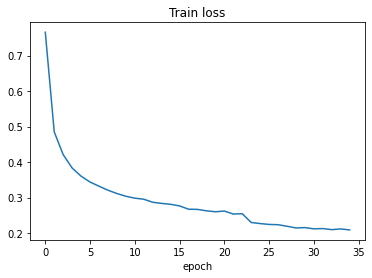

In [ ]:

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.title('Train loss')

### Train Accuracy
We can see the train accuracy starting at a very low value initially. As the number of epochs increase, the model learns and the train accuracy increases after some initial instabilty. We can see that the train accuracy is around 98-99% towards the final few epochs.

Text(0.5, 1.0, 'Train Accuracy')

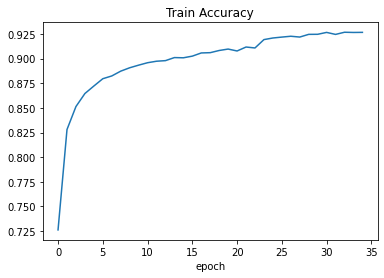

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.title('Train Accuracy')

### Validation Loss

We can see the validation loss being very unstable and exploding to a very high value initially. As the number of epochs increase, the model learns and the validation loss decreases after some initial instabilty. We can see that the train loss is around 0.07-0.09 towards the final few epochs.

Text(0.5, 1.0, 'Validation loss')

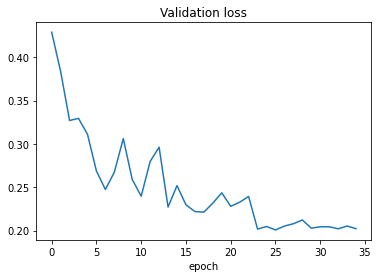

In [ ]:
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.title('Validation loss')

### Validation Accuracy

We can see the validation accuracy starting at a very low value initially and acting very unstable. As the number of epochs increase, the model learns and the validation accuracy increases after some initial instabilty. We can see that the validation accuracy is around 98-99% towards the final few epochs.

Text(0.5, 1.0, 'Validation Accuracy')

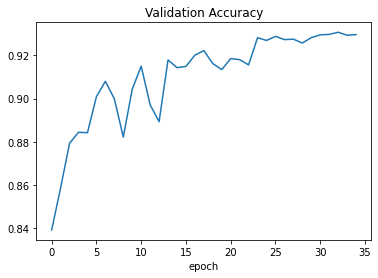

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.title('Validation Accuracy')

### Combining train and validation graphs

Let us visualize the train and validation graphs together for comparison. The blue line represents the train metric and the orange line represents the validation metric. 

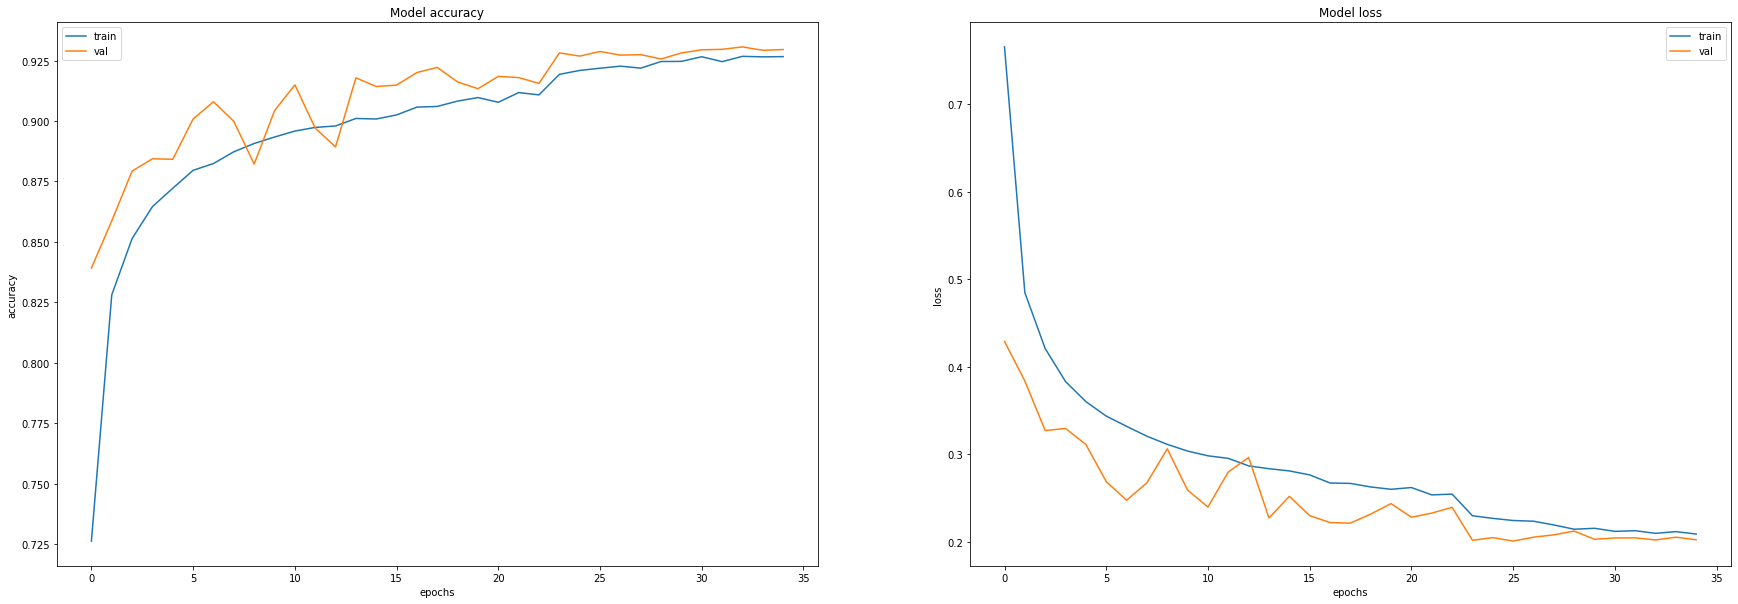

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric][:])
    ax[i].plot(model.history.history["val_" + metric][:])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Testing the model

It is now time to test our trained model using our test set! We will also plot the incorrectly classified images to get an idea of where and why the model might be misclassifying.

As always, we first import the needed packages.

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img,img_to_array

Next, we load the model from our best weights. In this case, the weights of the 39th epoch were the best. They are stored in the `snapshots` directory within the `content` directory.

In [ ]:
eval = model.evaluate(x_train,y_train)
print(eval)

1875/1875 [==============================] - 7s 3ms/step - loss: 0.1488 - accuracy: 0.9451
[0.14878273010253906, 0.9451000094413757]


In [ ]:
print('Test accuracy',eval[1]*100)
print('test error',eval[0])

Test accuracy 94.51000094413757
test error 0.14878273010253906
